<a href="https://colab.research.google.com/github/MoBanerjee/SC4001_Project/blob/main/ViT_PromptTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from transformers import ViTModel
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102

In [60]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [61]:
train_data = Flowers102(root='./data', split='train', transform=transform, download=True)
val_data = Flowers102(root='./data', split='val', transform=transform, download=True)
test_data = Flowers102(root='./data', split='test', transform=transform, download=True)

In [62]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:
class VisualPrompt(nn.Module):
    def __init__(self, prompt_length=5, embed_dim=768):
        super(VisualPrompt, self).__init__()

        self.prompt_tokens = nn.Parameter(torch.randn(prompt_length, embed_dim))

    def forward(self, x):

        batch_size = x.size(0)
        prompt_tokens = self.prompt_tokens.unsqueeze(0).expand(batch_size, -1, -1)
        return torch.cat((prompt_tokens, x), dim=1)

In [65]:
class ViTWithPrompt(nn.Module):
    def __init__(self, vit_model, prompt_length=5):
        super(ViTWithPrompt, self).__init__()
        self.vit_model = vit_model
        self.visual_prompt = VisualPrompt(prompt_length=prompt_length)
        self.classifier = nn.Linear(vit_model.config.hidden_size, 102)

    def forward(self, pixel_values):

        vit_outputs = self.vit_model(pixel_values=pixel_values, output_hidden_states=True)
        last_hidden_state = vit_outputs.last_hidden_state


        hidden_with_prompt = self.visual_prompt(last_hidden_state)


        outputs_with_prompt = self.vit_model.encoder(hidden_with_prompt)


        cls_output = outputs_with_prompt[0][:, 0]
        logits = self.classifier(cls_output)

        return logits

In [66]:

vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
vit_model.to(device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=2e-5)

In [68]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, score, epoch):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience} at epoch {epoch}')
            if self.counter >= self.patience:
                self.early_stop = True
                print(f'Early stopping at epoch {epoch}. No improvement in validation accuracy for {self.patience} consecutive epochs.')
        else:
            self.best_score = score
            self.counter = 0


In [69]:
def train_model(model, train_loader, val_loader, optimizer, criterion, model_save_path, epochs=5, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_val_accuracy = 0.0
    best_model_wts = None


    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total


        val_loss, val_accuracy = validate_model(model, val_loader, criterion)


        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)


        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}")


        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = model.state_dict()


        early_stopping(val_accuracy, epoch + 1)

        if early_stopping.early_stop:

            break


    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    if model_save_path != "None":
      torch.save(model.state_dict(), model_save_path)



    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history


In [70]:
def validate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()


            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = total_loss / len(val_loader)
    val_accuracy = correct / total
    return val_loss, val_accuracy

In [78]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

In [72]:
prompt_lengths = [5, 10, 15, 25, 50, 75, 100, 500, 1000]
best_prompt_length = 0
best_val_accuracy = 0.0


history_dict = {}

for prompt_length in prompt_lengths:
    print(f"\nTraining with prompt length: {prompt_length}")

    model = ViTWithPrompt(vit_model, prompt_length=prompt_length)
    model.to(device)


    train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history = train_model(
        model, train_loader, val_loader, optimizer, criterion, epochs=25, model_save_path='None'
    )


    history_dict[prompt_length] = {
        "train_loss": train_loss_history,
        "train_accuracy": train_accuracy_history,
        "val_loss": val_loss_history,
        "val_accuracy": val_accuracy_history
    }


    val_loss, val_accuracy = validate_model(model, val_loader, criterion)


    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_prompt_length = prompt_length

print(f"\nBest prompt length: {best_prompt_length} with validation accuracy: {best_val_accuracy:.2f}%")



Training with prompt length: 5
Epoch [1/25], Train Loss: 5.8908, Train Accuracy: 0.0539, Validation Loss: 3.4996, Validation Accuracy: 0.2392
Epoch [2/25], Train Loss: 2.0865, Train Accuracy: 0.5373, Validation Loss: 1.7817, Validation Accuracy: 0.6010
Epoch [3/25], Train Loss: 0.5381, Train Accuracy: 0.9020, Validation Loss: 1.1293, Validation Accuracy: 0.7382
Epoch [4/25], Train Loss: 0.0932, Train Accuracy: 0.9941, Validation Loss: 0.9375, Validation Accuracy: 0.7853
Epoch [5/25], Train Loss: 0.0229, Train Accuracy: 1.0000, Validation Loss: 0.8832, Validation Accuracy: 0.7833
EarlyStopping counter: 1 out of 5 at epoch 5
Epoch [6/25], Train Loss: 0.0106, Train Accuracy: 1.0000, Validation Loss: 0.8558, Validation Accuracy: 0.7912
Epoch [7/25], Train Loss: 0.0074, Train Accuracy: 1.0000, Validation Loss: 0.8443, Validation Accuracy: 0.7931
Epoch [8/25], Train Loss: 0.0058, Train Accuracy: 1.0000, Validation Loss: 0.8355, Validation Accuracy: 0.7971
Epoch [9/25], Train Loss: 0.0047, T

<ipython-input-77-9af5f900e13d>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(history_dict))


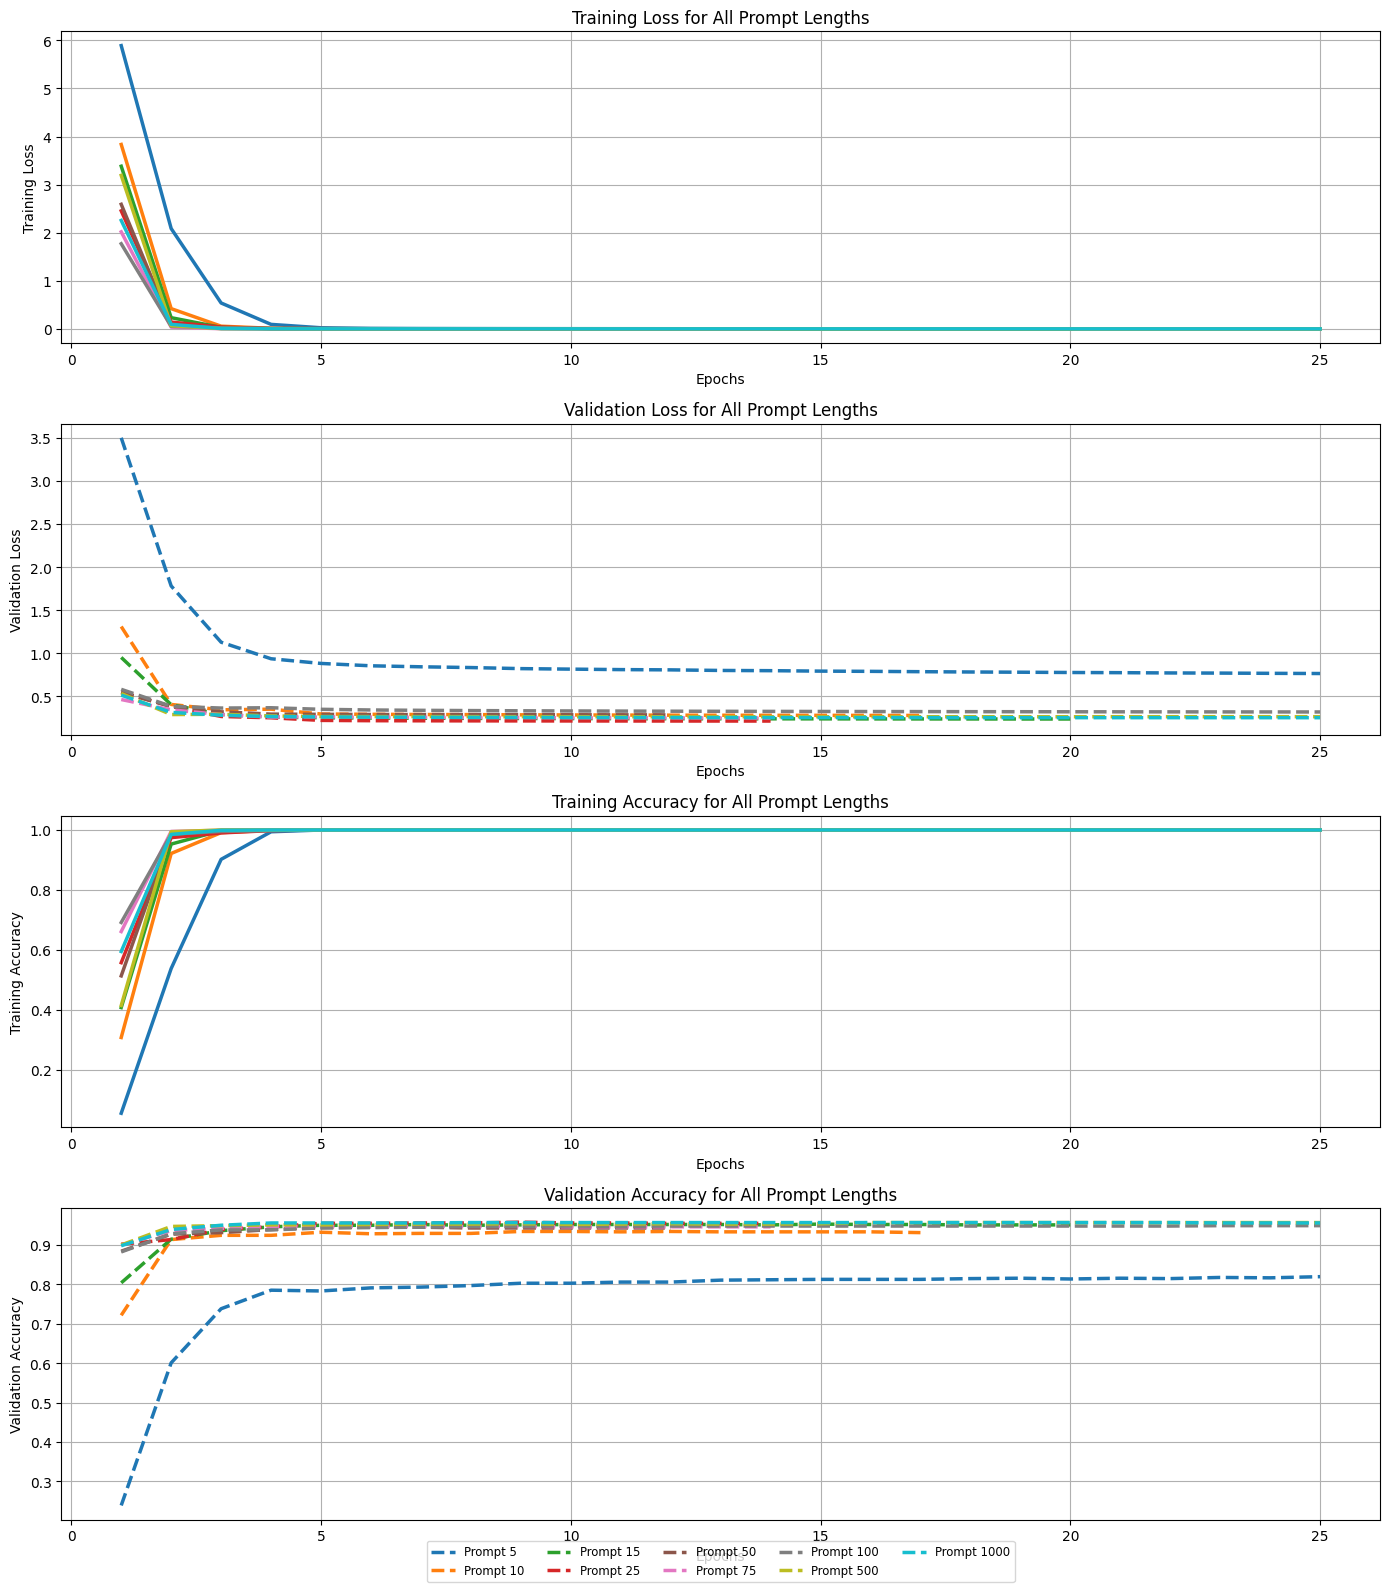

In [77]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


cmap = cm.get_cmap('tab10', len(history_dict))


plt.figure(figsize=(14, 16))


plt.subplot(4, 1, 1)
for i, (prompt_length, history) in enumerate(history_dict.items()):
    epochs = range(1, len(history["train_loss"]) + 1)
    color = cmap(i)
    plt.plot(epochs, history["train_loss"], label=f'Prompt {prompt_length}', color=color, linewidth=2.5)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss for All Prompt Lengths')
plt.grid()


plt.subplot(4, 1, 2)
for i, (prompt_length, history) in enumerate(history_dict.items()):
    epochs = range(1, len(history["val_loss"]) + 1)
    color = cmap(i)
    plt.plot(epochs, history["val_loss"], label=f'Prompt {prompt_length}', color=color, linestyle='--', linewidth=2.5)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for All Prompt Lengths')
plt.grid()


plt.subplot(4, 1, 3)
for i, (prompt_length, history) in enumerate(history_dict.items()):
    epochs = range(1, len(history["train_accuracy"]) + 1)
    color = cmap(i)
    plt.plot(epochs, history["train_accuracy"], label=f'Prompt {prompt_length}', color=color, linewidth=2.5)
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy for All Prompt Lengths')
plt.grid()


plt.subplot(4, 1, 4)
for i, (prompt_length, history) in enumerate(history_dict.items()):
    epochs = range(1, len(history["val_accuracy"]) + 1)
    color = cmap(i)
    plt.plot(epochs, history["val_accuracy"], label=f'Prompt {prompt_length}', color=color, linestyle='--', linewidth=2.5)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for All Prompt Lengths')
plt.grid()


plt.subplots_adjust(bottom=0.15)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5, fontsize='small')


plt.tight_layout()
plt.show()


In [74]:
print(f"\nTraining with the best prompt length: {best_prompt_length}")
best_model = ViTWithPrompt(vit_model, prompt_length=best_prompt_length)
best_model.to(device)
train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history=train_model(best_model, train_loader, val_loader, optimizer, criterion, epochs=25,model_save_path='Best_ViT_PromptTuning')


Training with the best prompt length: 500
Epoch [1/25], Train Loss: 1.4898, Train Accuracy: 0.7627, Validation Loss: 0.5065, Validation Accuracy: 0.9020
Epoch [2/25], Train Loss: 0.1046, Train Accuracy: 0.9794, Validation Loss: 0.3048, Validation Accuracy: 0.9431
Epoch [3/25], Train Loss: 0.0122, Train Accuracy: 0.9980, Validation Loss: 0.2658, Validation Accuracy: 0.9500
Epoch [4/25], Train Loss: 0.0011, Train Accuracy: 1.0000, Validation Loss: 0.2560, Validation Accuracy: 0.9539
Epoch [5/25], Train Loss: 0.0007, Train Accuracy: 1.0000, Validation Loss: 0.2506, Validation Accuracy: 0.9559
Epoch [6/25], Train Loss: 0.0005, Train Accuracy: 1.0000, Validation Loss: 0.2473, Validation Accuracy: 0.9549
EarlyStopping counter: 1 out of 5 at epoch 6
Epoch [7/25], Train Loss: 0.0004, Train Accuracy: 1.0000, Validation Loss: 0.2449, Validation Accuracy: 0.9539
EarlyStopping counter: 2 out of 5 at epoch 7
Epoch [8/25], Train Loss: 0.0004, Train Accuracy: 1.0000, Validation Loss: 0.2432, Validat

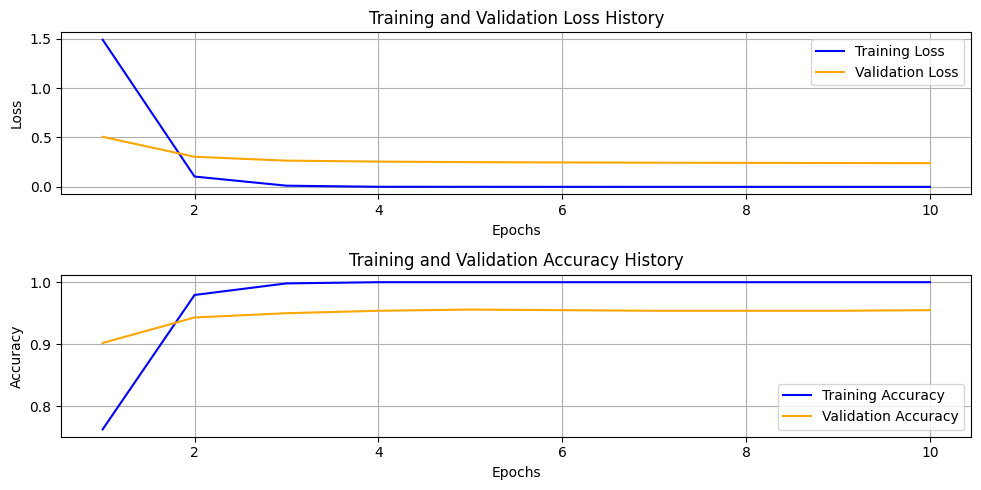

In [75]:

epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'orange', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracy_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy_history, 'orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [80]:
test_model(best_model, test_loader)

Test Accuracy: 95.30%
